In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# %cd /content/drive/MyDrive/Term 8/Term 8 Artificial Intelligence/folder
# %cd /content/drive/MyDrive/CellCount

In [6]:
!git clone https://github.com/Bjarten/early-stopping-pytorch.git ./earlystopping

fatal: destination path './earlystopping' already exists and is not an empty directory.


In [1]:
import os
import torch
import datetime
from model import *
from utils import *
import numpy as np
from tqdm import tqdm
from PIL import Image
from skimage import io
from torch.optim import Adam
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import transforms
from scipy.io import loadmat, savemat
from torch.utils.data import Dataset, DataLoader
from earlystopping.pytorchtools import EarlyStopping
from torch.utils.data.sampler import SubsetRandomSampler

# ignore

In [ ]:
%pylab inline
import torchvision.transforms as T
from torch.nn import ConstantPad2d
import numpy as np

def plot(imgs, orig_img, with_orig=True, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0]) + with_orig
    
    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False, figsize=(10, 10))
    fig = plt.figure(figsize=(100, 100))
    for row_idx, row in enumerate(imgs):
        row = [orig_img] + row if with_orig else row
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if with_orig:
        axs[0, 0].set(title='Original image')
        axs[0, 0].title.set_size(8)
    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()
    
def pad_with(vector, pad_width, iaxis, kwargs):
    pad_value = kwargs.get('padder', 10)
    vector[:pad_width[0]] = pad_value
    vector[-pad_width[1]:] = pad_value

def five_crop():
    root_dir = "./Train"
    fileNames = [i[:-4] for i in sorted(os.listdir(root_dir+"/Labels/"))]
    img_path = "./cropped_train/Images/"
    label_path = "./cropped_train/Labels/"
    for idx in range(len(fileNames)):
        size = 500
        img_name = os.path.join(root_dir,"Images", fileNames[idx])+".png"
        mask_name = os.path.join(root_dir,"Labels", fileNames[idx])+".mat"
        dictmat = loadmat(mask_name)
        orig_img = Image.open(img_name)
        (top_left, top_right, bottom_left, bottom_right, center) = T.FiveCrop(size=(size, size))(orig_img)
        cropped = [top_left, top_right, bottom_left, bottom_right, center]
        
        orig_img.save(img_path + fileNames[idx] + "_original.png")
        savemat(label_path + fileNames[idx] + "_original.mat", {"inst_map": dictmat["inst_map"]})    
        for img_idx in range(len(cropped)):
            name = ""
            labels = {}
            if img_idx == 0:
                name = "top_left"
                labels["inst_map"] = dictmat["inst_map"][0:size, 0:size]
            elif img_idx == 1:
                name = "top_right"
                labels["inst_map"] = dictmat["inst_map"][0:size, 1000-size:1000]
            elif img_idx == 2:
                name = "bottom_left"
                labels["inst_map"] = dictmat["inst_map"][1000-size:1000, 0:size]
            elif img_idx == 3:
                name = "bottom_right"
                labels["inst_map"] = dictmat["inst_map"][1000-size:1000, 1000-size:1000]
            elif img_idx == 4:
                name = "center"
                mid_height = 1000/2
                mid_weight = 1000/2
                labels["inst_map"] = dictmat["inst_map"][round(mid_height-size/2):round(mid_height+size/2), round(mid_weight-size/2):round(mid_weight+size/2)]
            
            ## pad images and labels
            cropped[img_idx] = T.Pad(padding=250, fill=(0,0,0), padding_mode='constant')(cropped[img_idx])
            labels["inst_map"] = np.pad(labels["inst_map"], 1, pad_with, padder=0)
            ## save 
            cropped[img_idx].save(img_path + fileNames[idx] + "_" +name+".png")            
            savemat(label_path + fileNames[idx] + "_" +name+".mat", labels)           
        plot(cropped, orig_img)
#         if idx == 0:        
#             break
    
five_crop()

In [ ]:
before = "./Train/Labels/train_1.mat"
after = "./cropped_train/Labels/train_1_original.mat"

dictmat_before = loadmat(before)
dictmat_after = loadmat(after)
print(dictmat_before["inst_map"] == dictmat_after["inst_map"])

a = np.arange(6)
a = a.reshape((2, 3))
print(a)
pad = np.pad(a, 2, pad_with, padder=100)
print(pad)

# Start here

In [2]:
def to_categorical(y, num_classes):
    """ 1-hot encodes a tensor """
    return np.eye(num_classes, dtype='uint8')[y]

# MULTI CLASS CELLS

class CellDataset(Dataset):

    def __init__(self, root_dir, transform=None):
        self.fileNames = [i[:-4] for i in sorted(os.listdir(root_dir+"/Labels/"))]
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.fileNames)
    
    """
    returns: tuple of
    - image
    - mask of size n x n with unique values/classes ranging from 0 to 4 
        0: background
        1: others (1)
        2: inflammatory(2)
        3: healthy epithelial(3) , dysplastic/malignant epithelial(4)
        4: fibroblast(5) , muscle(6) , endothelial(7)
    """
    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir,"Images",self.fileNames[idx])+".png"
        image = img = Image.open(img_name).convert('RGB')
        mask_name = os.path.join(self.root_dir,"Labels",self.fileNames[idx])+".mat"
        x = loadmat(mask_name)['type_map']
        x[(x==3)|(x==4)]=3
        x[(x==5)|(x==6)|(x==7)]=4
        x=np.pad(x.astype(int),6)
        if self.transform:
            image = self.transform(image)
        return image, to_categorical(x,5).transpose(2, 0, 1) #(num_classes=5, n, n)

In [3]:
transform = transforms.Compose([
    transforms.Pad(6),
    transforms.ToTensor()    
])

valid_size = 0.2
batch_size =1

# DataLoader
train_data = CellDataset(root_dir="./Train/train_500", transform = transform)
test_data = CellDataset(root_dir="./Test/test_500", transform = transform)

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# load training data in batches
train_loader = DataLoader(train_data,
                          batch_size=batch_size,
                          sampler=train_sampler,
                          num_workers=0)

# load validation data in batches
valid_loader = DataLoader(train_data,
                          batch_size=batch_size,
                          sampler=valid_sampler,
                          num_workers=0)

# load test data in batches
test_loader = DataLoader(test_data,
                        batch_size=batch_size,
                        num_workers=0)

## Training

In [4]:
def weighted_loss(pred,targ,bce_weight=0.5, smooth=1.):
    
    bce = F.binary_cross_entropy_with_logits(pred.squeeze(dim=1), targ)
    
    pred = torch.sigmoid(pred)
    
    pred = pred.contiguous().squeeze(dim=1)  
    targ = targ.contiguous()  

    intersection = (pred * targ).sum(dim=1).sum(dim=1)
    dice = (1 - ((2. * intersection + smooth) / (pred.sum(dim=1).sum(dim=1) + targ.sum(dim=1).sum(dim=1) + smooth)))
    
    loss = bce * bce_weight + dice.mean() * (1 - bce_weight)
    
    return loss


def dice_metric(pred,targ,bce_weight=0.5, smooth=1.):
    
    bce = F.binary_cross_entropy_with_logits(pred.squeeze(dim=1), targ)
    
    pred = torch.sigmoid(pred)
    
    pred = pred.contiguous().squeeze(dim=1)  
    targ = targ.contiguous()  

    intersection = (pred * targ).sum(dim=1).sum(dim=1)
    union = targ.sum() + pred.sum()
    

    dice = (1 - ((2. * intersection + smooth) / (pred.sum(dim=1).sum(dim=1) + targ.sum(dim=1).sum(dim=1) + smooth)))
    # print(intersection / union, dice)
    
    return dice


def train(model, device, train_loader, valid_loader, optimizer, epochs, patience, img_size):
    train_losses = []
    valid_losses = []
    avg_train_losses = [] # average training loss per epoch
    avg_valid_losses = [] # average validation loss per epoch
    valid_acc = 0
    
    os.makedirs("best_model_checkpoints", exist_ok=True)
    os.makedirs("model_checkpoints", exist_ok=True)
    save_path = f"best_model_checkpoints/{model.__class__.__name__}.pth"
    early_stopping = EarlyStopping(patience=patience, path=save_path, verbose=True)
    for epoch in tqdm(range(1, epochs + 1)):
        train_loss = 0
        valid_loss = 0
        score = 0
        """
        Trains the model on training data
        """
        for batch_idx, (data, target) in enumerate(train_loader):
            model.train()
            data, target = data.to(device), target.to(device).float()

            optimizer.zero_grad()
            output = model(data)
            loss = weighted_loss(output,target,bce_weight=0.3)
            loss.backward()
            optimizer.step()

            train_loss+=(loss/len(data)).item()
            train_losses.append(loss.item())
            # Find accuracy
        
        """
        Validate the model on validation data
        """
        model.eval()
        for batch_idx, (data, target) in enumerate(valid_loader):
            data, target = data.to(device), target.to(device).float()
            output = model(data)
            loss = weighted_loss(output,target,bce_weight=0.3)
            valid_loss+=(loss/len(data)).item()
            valid_losses.append(loss.item())
            pred = output.to('cpu').detach().numpy()[0][0]
            threshold=0.95
            pred[pred >= threshold] = 1
            pred[pred < threshold] = 0
            score+=get_dice_1(target, pred)

        train_loss /= len(train_loader)
        valid_loss /= len(valid_loader)
        score /= len(valid_loader)
        if score > valid_acc:
            valid_acc = score

        # average loss over an epoch
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)

        # clear lists to track next epoch
        train_losses = []
        valid_losses = []

        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(valid_loss, model)

        if early_stopping.early_stop:
            print("Early stopping")
            break

        torch.save(model.state_dict(), f"model_checkpoints/{model.__class__.__name__}_{img_size}_{epoch}.pth")
        print('Train Epoch: {} @ {} - Train Loss: {:.4f} - Valid Loss: {:.4f}'.format(epoch, datetime.datetime.now().time(), train_loss, valid_loss))

    # load the last checkpoint with the best model
    model.load_state_dict(torch.load(save_path)) 

    return  model, avg_train_losses, avg_valid_losses, valid_acc

In [5]:
# Set cpu / gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model and optimizer
model = build_model(device, "resnet")
model.to(device)

lr = 0.001
optimizer = Adam(model.parameters(), lr=lr)

In [6]:
print("Training")
# Training the model
epochs = 20 #60
lr = 0.001
patience = 10  # how long to wait after last time validation loss improved
optimizer = Adam(model.parameters(), lr=lr)
img_size = "ResNet-500x500"

model, train_loss, valid_loss, valid_acc = train(model, device, train_loader, valid_loader, optimizer, epochs, patience, img_size)

  0%|          | 0/20 [00:00<?, ?it/s]

Training
Validation loss decreased (inf --> 0.177664).  Saving model ...


  5%|▌         | 1/20 [00:21<06:43, 21.24s/it]

Train Epoch: 1 @ 04:13:59.521954 - Train Loss: 0.1922 - Valid Loss: 0.1777
Validation loss decreased (0.177664 --> 0.165830).  Saving model ...


 10%|█         | 2/20 [00:41<06:19, 21.06s/it]

Train Epoch: 2 @ 04:14:20.155580 - Train Loss: 0.1580 - Valid Loss: 0.1658
EarlyStopping counter: 1 out of 10


 15%|█▌        | 3/20 [01:02<05:54, 20.86s/it]

Train Epoch: 3 @ 04:14:40.562656 - Train Loss: 0.1453 - Valid Loss: 0.2018
Validation loss decreased (0.165830 --> 0.154952).  Saving model ...


 20%|██        | 4/20 [01:22<05:33, 20.81s/it]

Train Epoch: 4 @ 04:15:01.260171 - Train Loss: 0.1333 - Valid Loss: 0.1550
Validation loss decreased (0.154952 --> 0.152617).  Saving model ...


 25%|██▌       | 5/20 [01:43<05:11, 20.79s/it]

Train Epoch: 5 @ 04:15:22.005669 - Train Loss: 0.1258 - Valid Loss: 0.1526
Validation loss decreased (0.152617 --> 0.118392).  Saving model ...


 30%|███       | 6/20 [02:04<04:50, 20.78s/it]

Train Epoch: 6 @ 04:15:42.745354 - Train Loss: 0.1160 - Valid Loss: 0.1184
EarlyStopping counter: 1 out of 10


 35%|███▌      | 7/20 [02:24<04:28, 20.69s/it]

Train Epoch: 7 @ 04:16:03.225310 - Train Loss: 0.1106 - Valid Loss: 0.1794
EarlyStopping counter: 2 out of 10


 40%|████      | 8/20 [02:45<04:07, 20.59s/it]

Train Epoch: 8 @ 04:16:23.580578 - Train Loss: 0.1089 - Valid Loss: 0.1194
EarlyStopping counter: 3 out of 10


 45%|████▌     | 9/20 [03:05<03:45, 20.53s/it]

Train Epoch: 9 @ 04:16:43.964208 - Train Loss: 0.1038 - Valid Loss: 0.1993
Validation loss decreased (0.118392 --> 0.111560).  Saving model ...


 50%|█████     | 10/20 [03:26<03:25, 20.58s/it]

Train Epoch: 10 @ 04:17:04.683175 - Train Loss: 0.0963 - Valid Loss: 0.1116
EarlyStopping counter: 1 out of 10


 55%|█████▌    | 11/20 [03:46<03:04, 20.52s/it]

Train Epoch: 11 @ 04:17:25.062658 - Train Loss: 0.0912 - Valid Loss: 0.1865
EarlyStopping counter: 2 out of 10


 60%|██████    | 12/20 [04:07<02:43, 20.49s/it]

Train Epoch: 12 @ 04:17:45.472343 - Train Loss: 0.0866 - Valid Loss: 0.1174
EarlyStopping counter: 3 out of 10


 65%|██████▌   | 13/20 [04:27<02:23, 20.47s/it]

Train Epoch: 13 @ 04:18:05.906353 - Train Loss: 0.0854 - Valid Loss: 0.1204


 65%|██████▌   | 13/20 [04:31<02:26, 20.89s/it]


KeyboardInterrupt: 

In [7]:
print("DICE score:", valid_acc)

DICE score: 0.5006269000611495


# Graphs

In [8]:
def plot_graph(train_loss, valid_loss):
  fig = plt.figure(figsize=(10,8))
  plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
  plt.plot(range(1,len(valid_loss)+1),valid_loss,label='Validation Loss')

  # find position of lowest validation loss
  minposs = valid_loss.index(min(valid_loss))+1 
  plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

  plt.xlabel('epochs')
  plt.ylabel('loss')
  plt.ylim(0, 0.5) # consistent scale
  plt.xlim(0, len(train_loss)+1) # consistent scale
  plt.grid(True)
  plt.legend()
  plt.tight_layout()
  plt.show()
  fig.savefig('loss_plot.png', bbox_inches='tight')

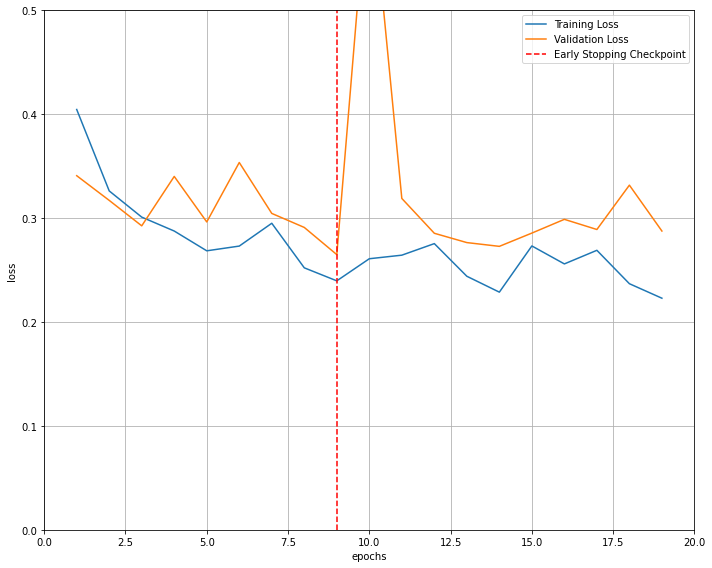

In [9]:
plot_graph(train_loss, valid_loss)

# Load model


In [ ]:
# load saved model
def load_model(model):
  path = f"model_checkpoints/{model.__class__.__name__}.pt"
  model.load_state_dict(torch.load(path)) 
  model.eval()
  return model
model = load_model(model)

# Test

In [19]:
"""
0: black: background
1: red: others (1)
2: pink: inflammatory(2)
3: dark blue: healthy epithelial(3) , dysplastic/malignant epithelial(4)
4: light blue: fibroblast(5) , muscle(6) , endothelial(7)
"""
# params: 5 x n x n numpy or n x n x 5
def printColoredMask(npMask,numchannel=5): 
    print("input printcolouredmask",npMask.shape)
    if npMask.shape[-1]!=5:
        npMask=npMask.transpose(1, 2, 0)
    print("printcolouredmask",npMask.shape)
    finalnpMask=np.where(npMask[:,:,1]==1,255,0) # one color
    finalnpMask=finalnpMask[:,:,None]
    temp=np.where((npMask[:,:,2]==1)|(npMask[:,:,4]==1),255,0) # one color
    finalnpMask = np.concatenate((finalnpMask,temp[:, :, None]),axis=2)
    temp=np.where((npMask[:,:,3]==1)|(npMask[:,:,4]==1),255,0) # one color
    finalnpMask = np.concatenate((finalnpMask,temp[:, :, None]),axis=2)
#     print(finalnpMask.shape) #(n, n, 3)

#     finalnpMask=np.where(npMask==1,255,0) # one color
#     finalnpMask=finalnpMask[:,:,None]
#     temp=np.where((npMask==2)|(npMask==4),255,0) # one color
#     finalnpMask = np.concatenate((finalnpMask,temp[:, :, None]),axis=2)
#     temp=np.where((npMask==3)|(npMask==4),255,0) # one color
#     finalnpMask = np.concatenate((finalnpMask,temp[:, :, None]),axis=2)
#     print(finalnpMask.shape) #(n, n, 3)
    plt.imshow(finalnpMask)
    plt.show()

In [25]:
def test(model, device, data, target):
    print("Input Image")
    plt.imshow(data[0].numpy().transpose(1, 2, 0))
    plt.show()
    outputs = model(data.to(device))[0]
    pred = outputs.to('cpu').detach()
    pred=F.softmax(pred, dim=0)#long the channel
    pred=pred.numpy()
#     print("here",pred[0])
#     return pred

    print("Predicted Mask Sigmoid")
    printColoredMask(pred)
#     plt.imshow(pred,cmap='gray')
#     plt.show()
#     threshold=0.95
#     pred[pred >= threshold] = 1
#     pred[pred < threshold] = 0
#     print("Predicted Mask Binary")
#     plt.imshow(pred,cmap='gray')
#     plt.show()
    print("Actual Mask")
    printColoredMask(target[0].numpy())
#     plt.imshow(target[0],cmap='gray')
#     plt.show()

    # iou
    iou_score = iou(target, pred)
    print("iou score:", iou_score)

    # kernel keeps dying here ------------------------
#     # AJI
#     aji_score = get_fast_aji(target, pred)
#     print("AJI score:", aji_score)

#     # AJI+
#     aji_plus_score = get_fast_aji_plus(target, pred)
#     print("AJI+ score:", aji_plus_score)

#     # PQ
#     pq_score = get_fast_pq(target, pred)[0]
#     print("Detection Quality (DQ):", pq_score[0])
#     print("Segmentation Quality (SQ):", pq_score[1])
#     print("Panoptic Quality (PQ):", pq_score[2])

#     # Dice2
#     dice2_score = get_fast_dice_2(target, pred)
#     print("Dice2 score:", dice2_score, "\n")
    
#     dice_score = get_dice_1(target, pred)
#     print("Dice score:", dice_score, "\n")

#     return iou_score, aji_score, aji_plus_score, pq_score, dice2_score

Input Image


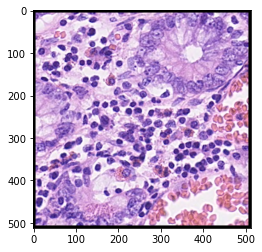

Predicted Mask Sigmoid
input printcolouredmask (5, 512, 512)
printcolouredmask (512, 512, 5)


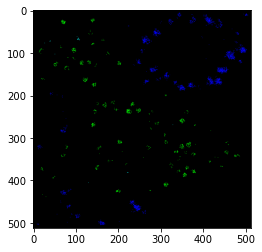

Actual Mask
input printcolouredmask (5, 512, 512)
printcolouredmask (512, 512, 5)


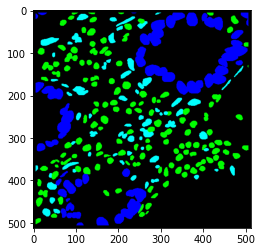

iou score: 0.20295218378915716


In [ ]:
# Testing the model
for data, target in test_loader:
    iou_score, aji_score, aji_plus_score, pq_score, dice2_score = test(model, device, data, target)
#     x=    test(model, device, data, target)

#     print(target[0])
#     print(list(np.unique(target[0])))
    break

Ignore : own notes

input printcolouredmask (5, 512, 512)
printcolouredmask (512, 512, 5)


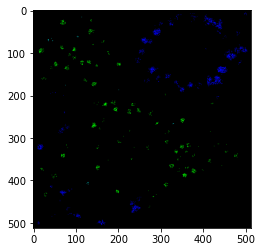

(5, 512, 512)


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [24]:
# printColoredMask(x)
# print(x.shape)
# y=x[1,:,:]
# print(list(np.unique(y)))
# unique, counts = np.unique(y, return_counts=True)
# print(dict(zip(unique, counts)))

In [14]:
unique, counts = np.unique(x, return_counts=True)
print(dict(zip(unique, counts)))

{0.0: 1048576, 1.0: 262144}


In [ ]:
print(x)
print(list(np.unique(x)))

In [12]:
print(target[0])
print(list(np.unique(target[0])))

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])
[0, 2, 3, 4]


In [13]:
unique, counts = np.unique(target[0], return_counts=True)
print(dict(zip(unique, counts)))

{0: 202567, 2: 23467, 3: 24659, 4: 11451}


In [14]:
print(target[0].shape)

torch.Size([512, 512])


In [28]:
print(pred)
# print(list(np.unique(pred)))

NameError: name 'pred' is not defined

In [21]:
%reset array

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [24]:
%reset_selective -f "^true$"

In [25]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [28]:
import gc
gc.collect()

0